### Install essential libraries

In [ ]:
%pip install accelerate==0.26.1 bitsandbytes==0.42.0 datasets==2.16.1 peft==0.8.1 transformers==4.37.2 einops==0.7.0 torch==2.1.0 accelerate==0.26.1

In [ ]:
!pip install bitsandbytes datasets peft einops

In [ ]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

### Prepare model

In [1]:
from transformers import set_seed

set_seed(42)

In [14]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    #quantization_config=BitsAndBytesConfig(
    #    load_in_4bit=True,
    #    bnb_4bit_compute_dtype=torch.bfloat16,
    #    bnb_4bit_quant_type="nf4",
    #),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",          
)

/home/kreinin.mv/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) 

lora_config = LoraConfig(
    r=32, 
    lora_alpha=32, 
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

### Prepare dataset

In [5]:
import pandas as pd
df = pd.read_csv('data.csv')
df.head()

,bad_prompts,improved_prompts,Mistral_prompts,gpt-4o-mini_prompts
0,Write a program that calculates the area of a ...,"""Implement a Python program that takes the le...",Code a program to determine the area of any gi...,"""Write a Python function to calculate the area..."
1,Build an app that tracks daily fitness activities,"""Design and develop a mobile app for iOS and ...",Develop an application to monitor and record d...,Create a fitness tracking app that logs daily ...
2,Make a program that simulates a blackjack game.,"""Create a Java program that simulates a black...",Programming task: Design a blackjack game simu...,Create a Python program that simulates a black...
3,Write code to analyze a large dataset and extr...,"""Develop a data analysis script in Python tha...","""Develop and implement a data analysis strateg...","""Generate Python code to analyze a large CSV d..."
4,Create a chatbot using natural language proces...,"""Build an AI-powered chatbot using Python, T...",Develop a conversational AI system utilizing a...,Create an engaging chatbot that can answer use...


In [6]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files="./data.csv", split="train")
dataset = dataset.train_test_split(test_size=0.1, seed=30)

In [7]:
import os
from functools import partial

IGNORE_INDEX=-100


def tokenize(input_dict, max_length):
    input_ids, attention_mask, labels = [], [], []
    
    
    user_message = f"""###System:
Fix the following prompt.
###Prompt:
{input_dict['bad_prompts']} 
###Answer
"""
    user_tokenized = tokenizer(user_message, truncation=False, add_special_tokens=False)
    input_ids += user_tokenized["input_ids"]
    attention_mask += user_tokenized["attention_mask"]
    labels += [IGNORE_INDEX] * len(user_tokenized["input_ids"])  # Ignore user input in labels
    
    
    assistant_message = input_dict['improved_prompts']
    assistant_tokenized = tokenizer(assistant_message, truncation=False, add_special_tokens=False)
    
    input_ids += assistant_tokenized["input_ids"]
    attention_mask += assistant_tokenized["attention_mask"]
    labels += assistant_tokenized["input_ids"]  # Only assistant's answer contributes to labels
    # Truncate to max length
    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024), # max sample length 1024 tokens, enough for this dataset
    batched=False, 
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

longest sample: 69 tokens


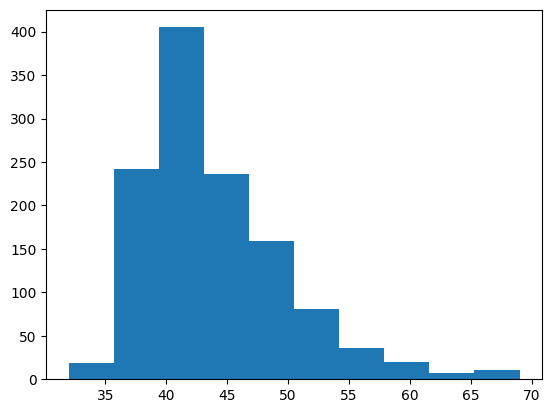

In [8]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()

In [32]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])
    
    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend(pad_len * [tokenizer.pad_token_id] )   
        labels.extend(pad_len * [IGNORE_INDEX] )    
        attention_mask.extend( pad_len * [0] ) 

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

In [33]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=2     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=2e-5  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)


trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

In [34]:
torch.cuda.empty_cache()

trainer.train()

/home/kreinin.mv/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/kreinin.mv/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TrainOutput(global_step=680, training_loss=0.5141849350184202, metrics={'train_runtime': 1789.9554, 'train_samples_per_second': 12.224, 'train_steps_per_second': 0.38, 'total_flos': 1.720428108220416e+16, 'train_loss': 0.5141849350184202, 'epoch': 19.89})

In [39]:
user_message = """###System:
Fix the following prompt.
###Prompt:
{}
###Answer
"""

questions = [
"Can losartan reduce brain atrophy in Alzheimer's disease?",
"What is CHARMS with respect to medical review of predictive modeling?",
"Which splicing factors have been associated with alternative splicing in PLN R14del hearts?",
"What are the most common mutation types in Duchenne muscular Dystrophy?",
"What is the target of Litifilimab?",
"What is AUROC in context of predictive modeling?",
"Is PRP-40 regulation of microexons a conserved phenomenon?",
"Is casimersen effective for the treatment of Duchenne muscular dystrophy?",
"Which are the targets of Tirzepatide?",
"Is medical hydrology the same as Spa therapy?",
"How does CYP1A2 relate to coffee consumption and appetite?",
"Is eteplirsen effective for the treatment of Duchenne muscular dystrophy?",
"What is the use of darolutamide?",
"What are the main clinical features of small-fiber neuropathy (SFN)?",
"When was Keytruda approved by the FDA for the treatment of metastatic non-small cell lung cancer?",
"Which gene therapies are under investigation for Duchenne muscular dystrophy?",
]

for q in questions:
    user_tokenized = tokenizer(user_message.format(q), truncation=False, add_special_tokens=False, return_tensors='pt')
    input_ids = user_tokenized["input_ids"].cuda()
    attention_mask = user_tokenized["attention_mask"].cuda()

    # Generate optimized prompt
    output_tokens = model.generate(
            input_ids = input_ids,
            max_new_tokens=100,
            temperature=0.7,
            repetition_penalty=1.2,

    )
    output = tokenizer.decode(
        output_tokens[0], skip_special_tokens=True
    )
    print ('Before: ', q)
    print ('After: ', output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Can losartan reduce brain atrophy in Alzheimer's disease?
After:  ###System:
Fix the following prompt.
###Prompt:
Can losartan reduce brain atrophy in Alzheimer's disease?
###Answer
Evaluate the potential neuroprotective effects of losartan on cognitive decline and hippocampal volume loss in mild to moderate Alzheimer's disease patients. OUTPUT: "What are the implications of losartan for cognitive function and neurodegeneration in early-stage Alzheimer's disease?"



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What is CHARMS with respect to medical review of predictive modeling?
After:  ###System:
Fix the following prompt.
###Prompt:
What is CHARMS with respect to medical review of predictive modeling?
###Answer
Discuss the role and importance of CHARMS in the process of medical model validation using predictive analytics.    




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Which splicing factors have been associated with alternative splicing in PLN R14del hearts?
After:  ###System:
Fix the following prompt.
###Prompt:
Which splicing factors have been associated with alternative splicing in PLN R14del hearts?
###Answer
What are the specific splice factor isoforms and their roles in regulating alternative splicing of pre-mRNA transcripts in human Plasmodium falciparum infected red blood cells?  OUTPUT: What is the role of different splice factor isoforms in regulating alternative splicing of pre-mRNA transcripts in human Plasmodium falciparum infected red blood cells?



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What are the most common mutation types in Duchenne muscular Dystrophy?
After:  ###System:
Fix the following prompt.
###Prompt:
What are the most common mutation types in Duchenne muscular Dystrophy?
###Answer
Discuss the genetic basis and implications of different mutations associated with Duchenne Muscular Dystrophy.  OUTPUT: Describe the role of specific gene mutations in causing Duchenne Muscular Dystrophy.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What is the target of Litifilimab?
After:  ###System:
Fix the following prompt.
###Prompt:
What is the target of Litifilimab?
###Answer
Explain how litifilimab works as a targeted therapy for cancer treatment.  OUTPUT: Describe the mechanism and potential applications of litifilimab in treating specific types of cancers.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What is AUROC in context of predictive modeling?
After:  ###System:
Fix the following prompt.
###Prompt:
What is AUROC in context of predictive modeling?
###Answer
Explain the concept and importance of Area Under Receiver Operating Characteristic Curve (AUROC) in evaluating model performance for binary classification tasks.    
##Data Visualization: 
Create a visually appealing bar chart using Python libraries such as Matplotlib, Seaborn, or Plotly to represent data from a CSV file containing information about different car models' fuel efficiency ratings.    Can you customize the color scheme, add labels, and save the plot as an image file?    How can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Is PRP-40 regulation of microexons a conserved phenomenon?
After:  ###System:
Fix the following prompt.
###Prompt:
Is PRP-40 regulation of microexons a conserved phenomenon?
###Answer
Evaluate the conservation and evolutionary significance of Prp40 in regulating exon splicing across species.  OUTPUT: "Compare and contrast the role of protein Prp40 in regulating exon splicing among different eukaryotic organisms, considering its potential implications for evolution."



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Is casimersen effective for the treatment of Duchenne muscular dystrophy?
After:  ###System:
Fix the following prompt.
###Prompt:
Is casimersen effective for the treatment of Duchenne muscular dystrophy?
###Answer
Evaluate the effectiveness and potential side effects of Casimersen in treating DMD patients.  OUTPUT: "What are the current findings on the efficacy and safety profile of Casimirsens as a therapeutic option for Duchenne Muscular Dystrophy (DMD)?"



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Which are the targets of Tirzepatide?
After:  ###System:
Fix the following prompt.
###Prompt:
Which are the targets of Tirzepatide?
###Answer
Explain how tirzepatide works as an anti-diabetic drug and its potential applications in treating other metabolic disorders.  OUTPUT: Describe the mechanism of action and potential therapeutic uses of tirzepatide, a novel GLP-1 receptor agonist for diabetes treatment.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Is medical hydrology the same as Spa therapy?
After:  ###System:
Fix the following prompt.
###Prompt:
Is medical hydrology the same as Spa therapy?
###Answer
Discuss the role of medical hydrology in spa treatments and their effects on human health.  OUTPUT: "Explain how medical hydrology is used in spa therapies to improve human health."



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  How does CYP1A2 relate to coffee consumption and appetite?
After:  ###System:
Fix the following prompt.
###Prompt:
How does CYP1A2 relate to coffee consumption and appetite?
###Answer
Discuss the role of CYP1A2 in regulating caffeine metabolism, its effects on human health, and potential implications for weight management strategies.  OUTPUT: "Explain how genetic variations in CYP1A2 can influence an individual's response to caffeine intake and their risk of developing obesity."



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  Is eteplirsen effective for the treatment of Duchenne muscular dystrophy?
After:  ###System:
Fix the following prompt.
###Prompt:
Is eteplirsen effective for the treatment of Duchenne muscular dystrophy?
###Answer
Evaluate the effectiveness and safety profile of exon skipping therapy in treating DMD patients.  OUTPUT: "What are the potential benefits and risks associated with exon skipping therapy as a treatment option for Duchenne Muscular Dystrophy (DMD)?"



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What is the use of darolutamide?
After:  ###System:
Fix the following prompt.
###Prompt:
What is the use of darolutamide?
###Answer
Discuss the potential uses and applications of darolutamide in treating prostate cancer.  OUTPUT: "Explain the mechanisms and clinical implications of using darolutamide as a treatment for advanced prostate cancer."



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  What are the main clinical features of small-fiber neuropathy (SFN)?
After:  ###System:
Fix the following prompt.
###Prompt:
What are the main clinical features of small-fiber neuropathy (SFN)?
###Answer
Discuss the diagnostic criteria and clinical manifestations of small-fiber neuropathy in a comprehensive manner.  OUTPUT: Describe the diagnostic criteria, classification, and clinical presentation of small fiber neuropathies.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before:  When was Keytruda approved by the FDA for the treatment of metastatic non-small cell lung cancer?
After:  ###System:
Fix the following prompt.
###Prompt:
When was Keytruda approved by the FDA for the treatment of metastatic non-small cell lung cancer?
###Answer
Discuss the approval and usage of immunotherapy drugs like Keytruda in treating advanced cancers.  OUTPUT: What are the mechanisms behind the effectiveness of immune checkpoint inhibitors, such as Keytruda, in treating various types of cancer?

Before:  Which gene therapies are under investigation for Duchenne muscular dystrophy?
After:  ###System:
Fix the following prompt.
###Prompt:
Which gene therapies are under investigation for Duchenne muscular dystrophy?
###Answer
Discuss the potential applications and challenges of gene therapy in treating genetic disorders like Duchenne muscular dystrophy.  OUTPUT: "Evaluate the current status and future prospects of gene therapy as a treatment option for rare genetic disorders

In [42]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): ModulesToSaveWrapper(
          (original_module): Embedding(51200, 2560)
          (modules_to_save): ModuleDict(
            (default): Embedding(51200, 2560)
          )
        )
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
     